<a href="https://colab.research.google.com/github/MMol04/CorVsPar/blob/main/Modelos/CorianderVsParsleyMobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NO CERRAR COLLAB DESPUES DE COMPILAR**

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from google.colab import drive
import os

In [ ]:
# Accessing My Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Constants
BATCH_SIZE = 16
EPOCHS = 50
IMG_SIZE = 96
NUM_CLASSES = 1

In [ ]:
# Paths
train_path = "/content/drive/MyDrive/BD_cor_par/train/"
test_path = "/content/drive/MyDrive/BD_cor_par/test/"
MODEL_PATH_ROOT = "/content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/"
MODELTF_PATH = MODEL_PATH_ROOT + 'modelFold3.h5'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 1615 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 404 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['coriander', 'parsley']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def evalModelByFold(num_classes, train_ds, valid_fold, val_grl, nFold=0):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = MobileNetV2(include_top=False, input_tensor=inputs, weights="imagenet")
    base_model.trainable = True

    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="MobileNetV2")
    #model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    metrics = ["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)

    checkpointer = ModelCheckpoint(MODEL_PATH_ROOT + f"modelFold{nFold}.h5", verbose=1, save_best_only=True)

    results = model.fit(train_ds, validation_data=valid_fold, epochs=EPOCHS, callbacks=[checkpointer])
    np.save(MODEL_PATH_ROOT + f'model_history_fold{nFold}.npy', results.history)

    loss, accuracy, recall, precision = model.evaluate(valid_fold, batch_size=BATCH_SIZE, verbose=0)
    lossVAL, accuracyVAL, recallVAL, precisionVAL = model.evaluate(val_grl, batch_size=BATCH_SIZE, verbose=0)
    return loss, accuracy, recall, precision, results, model, lossVAL, accuracyVAL, recallVAL, precisionVAL

In [ ]:
'''def run_Experiment_TrainModel(train_ds, val_ds):
    kfold = KFold(n_splits=10)
    scoreloss=[]
    scoresaccuracy = []
    scoresrecall = []
    scoresprecision = []
    scoresf1 =[]

    train_images, train_labels = zip(*[(x, y) for x, y in train_ds])
    val_images, val_labels = zip(*[(x, y) for x, y in val_ds])

    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)
    val_images = np.concatenate(val_images)
    val_labels = np.concatenate(val_labels)

    for k, (train, test) in enumerate(kfold.split(train_images)):
        trainX, trainY = train_images[train], train_labels[train]
        testX, testY = train_images[test], train_labels[test]

        train_fold_ds = tf.data.Dataset.from_tensor_slices((trainX, trainY)).batch(BATCH_SIZE)
        val_fold_ds = tf.data.Dataset.from_tensor_slices((testX, testY)).batch(BATCH_SIZE)

        loss, accuracy, recall, precision, results, model = evalModelByFold(NUM_CLASSES, train_fold_ds, val_fold_ds, k)

        f1score = (2*precision*recall)/(precision+recall)
        scoreloss.append(loss)
        scoresaccuracy.append(accuracy)
        scoresrecall.append(recall)
        scoresprecision.append(precision)
        scoresf1.append(f1score)

    data_scores = list(zip(scoreloss, scoresaccuracy, scoresrecall, scoresprecision, scoresf1)) #para el csv
    np.savetxt(MODEL_PATH_ROOT + 'metricvaluesbyFold.csv', data_scores, delimiter=',')
    return results, model'''

"def run_Experiment_TrainModel(train_ds, val_ds):\n    kfold = KFold(n_splits=10)\n    scoreloss=[]\n    scoresaccuracy = []\n    scoresrecall = []\n    scoresprecision = []\n    scoresf1 =[]\n\n    train_images, train_labels = zip(*[(x, y) for x, y in train_ds])\n    val_images, val_labels = zip(*[(x, y) for x, y in val_ds])\n\n    train_images = np.concatenate(train_images)\n    train_labels = np.concatenate(train_labels)\n    val_images = np.concatenate(val_images)\n    val_labels = np.concatenate(val_labels)\n\n    for k, (train, test) in enumerate(kfold.split(train_images)):\n        trainX, trainY = train_images[train], train_labels[train]\n        testX, testY = train_images[test], train_labels[test]\n\n        train_fold_ds = tf.data.Dataset.from_tensor_slices((trainX, trainY)).batch(BATCH_SIZE)\n        val_fold_ds = tf.data.Dataset.from_tensor_slices((testX, testY)).batch(BATCH_SIZE)\n\n        loss, accuracy, recall, precision, results, model = evalModelByFold(NUM_CLASSES, t

In [ ]:
def run_Experiment_TrainModel(train_ds, val_ds):
    kfold = KFold(n_splits=10)
    best_model = None
    best_val_score = float('-inf')
    best_results = None
    scoreloss=[]
    scoresaccuracy = []
    scoresrecall = []
    scoresprecision = []
    scoresf1 =[]

    scorelossV=[]
    scoresaccuracyV = []
    scoresrecallV = []
    scoresprecisionV = []
    scoresf1V =[]

    train_images, train_labels = zip(*[(x, y) for x, y in train_ds])
    val_images, val_labels = zip(*[(x, y) for x, y in val_ds])

    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)
    val_images = np.concatenate(val_images)
    val_labels = np.concatenate(val_labels)

    for k, (train, test) in enumerate(kfold.split(train_images)):
        trainX, trainY = train_images[train], train_labels[train]
        testX, testY = train_images[test], train_labels[test]

        train_fold_ds = tf.data.Dataset.from_tensor_slices((trainX, trainY)).batch(BATCH_SIZE)
        val_fold_ds = tf.data.Dataset.from_tensor_slices((testX, testY)).batch(BATCH_SIZE)

        loss, accuracy, recall, precision, results, model, lossVAL, accuracyVAL, recallVAL, precisionVAL = evalModelByFold(NUM_CLASSES, train_fold_ds, val_fold_ds, val_ds, k)

        f1score = (2*precision*recall)/(precision+recall)
        scoreloss.append(loss)
        scoresaccuracy.append(accuracy)
        scoresrecall.append(recall)
        scoresprecision.append(precision)
        scoresf1.append(f1score)

        f1scoreV = (2*precisionVAL*recallVAL)/(precisionVAL+recallVAL)
        scorelossV.append(lossVAL)
        scoresaccuracyV.append(accuracyVAL)
        scoresrecallV.append(recallVAL)
        scoresprecisionV.append(precisionVAL)
        scoresf1V.append(f1scoreV)

    data_scores = list(zip(scoreloss, scoresaccuracy, scoresrecall, scoresprecision, scoresf1, scorelossV, scoresaccuracyV, scoresrecallV, scoresprecisionV, scoresf1V)) #para el csv
    np.savetxt(MODEL_PATH_ROOT + 'MetricasMNV2.csv', data_scores, delimiter=',')
    return results

In [ ]:
#run_Experiment_TrainModel(train_ds, val_ds)

In [ ]:
# Obtener el mejor modelo
results=run_Experiment_TrainModel(train_ds, val_ds)



Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.4186 - accuracy: 0.8334 - recall_21: 0.8487 - precision_21: 0.8238
Epoch 1: val_loss improved from inf to 18.84812, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 [==============================] - 26s 50ms/step - loss: 0.4186 - accuracy: 0.8334 - recall_21: 0.8487 - precision_21: 0.8238 - val_loss: 18.8481 - val_accuracy: 0.4506 - val_recall_21: 0.0000e+00 - val_precision_21: 0.0000e+00
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9153 - recall_21: 0.9161 - precision_21: 0.9148
Epoch 2: val_loss improved from 18.84812 to 8.28132, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold0.h5
91/91 [==============================] - 3s 38ms/step - loss: 0.2077 - accuracy: 0.9153 - recall_21: 0.9161 - precision_21: 0.9148 - val_loss: 8.2813 - val_accuracy: 0.4506 - val_recall_21: 0.0000e+00 - val_precision_21: 0.0000e+00
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9429 - recall_21: 0.9422 - precision_21: 0.9435
Epoch 3: val_loss improved from 8.28132 to 1.46461, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/m

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.6635 - recall_22: 0.7296 - precision_22: 0.6493
Epoch 1: val_loss improved from inf to 21.25777, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold1.h5
91/91 [==============================] - 28s 50ms/step - loss: 0.7410 - accuracy: 0.6635 - recall_22: 0.7296 - precision_22: 0.6493 - val_loss: 21.2578 - val_accuracy: 0.5062 - val_recall_22: 0.0000e+00 - val_precision_22: 0.0000e+00
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.9305 - recall_22: 0.9293 - precision_22: 0.9332
Epoch 2: val_loss improved from 21.25777 to 20.95467, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold1.h5
91/91 [==============================] - 4s 40ms/step - loss: 0.2213 - accuracy: 0.9305 - recall_22: 0.9293 - precision_22: 0.9332 - val_loss: 20.9547 - val_accuracy: 0.5062 - val_recall_22: 0.0000e+00 - val_precision_22:

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.6421 - recall_23: 0.6854 - precision_23: 0.6334
Epoch 1: val_loss improved from inf to 7.36495, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold2.h5
91/91 [==============================] - 27s 61ms/step - loss: 0.6887 - accuracy: 0.6421 - recall_23: 0.6854 - precision_23: 0.6334 - val_loss: 7.3649 - val_accuracy: 0.5247 - val_recall_23: 1.0000 - val_precision_23: 0.5247
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.8954 - recall_23: 0.9097 - precision_23: 0.8855
Epoch 2: val_loss did not improve from 7.36495
91/91 [==============================] - 3s 34ms/step - loss: 0.2766 - accuracy: 0.8954 - recall_23: 0.9097 - precision_23: 0.8855 - val_loss: 13.7511 - val_accuracy: 0.5247 - val_recall_23: 1.0000 - val_precision_23: 0.5247
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9408 - r

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.8725 - accuracy: 0.6607 - recall_24: 0.6445 - precision_24: 0.6728
Epoch 1: val_loss improved from inf to 9.16309, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold3.h5
91/91 [==============================] - 26s 49ms/step - loss: 0.8725 - accuracy: 0.6607 - recall_24: 0.6445 - precision_24: 0.6728 - val_loss: 9.1631 - val_accuracy: 0.5123 - val_recall_24: 0.0000e+00 - val_precision_24: 0.0000e+00
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.3232 - accuracy: 0.8926 - recall_24: 0.8630 - precision_24: 0.9204
Epoch 2: val_loss improved from 9.16309 to 6.49696, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold3.h5
91/91 [==============================] - 4s 39ms/step - loss: 0.3232 - accuracy: 0.8926 - recall_24: 0.8630 - precision_24: 0.9204 - val_loss: 6.4970 - val_accuracy: 0.5309 - val_recall_24: 1.0000 - val_precision_24: 0.5097
E

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.5442 - accuracy: 0.8217 - recall_25: 0.8260 - precision_25: 0.8204
Epoch 1: val_loss improved from inf to 9.02771, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold4.h5
91/91 [==============================] - 27s 59ms/step - loss: 0.5442 - accuracy: 0.8217 - recall_25: 0.8260 - precision_25: 0.8204 - val_loss: 9.0277 - val_accuracy: 0.4691 - val_recall_25: 0.0000e+00 - val_precision_25: 0.0000e+00
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.9112 - recall_25: 0.9014 - precision_25: 0.9203
Epoch 2: val_loss improved from 9.02771 to 0.95170, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold4.h5
91/91 [==============================] - 4s 41ms/step - loss: 0.2767 - accuracy: 0.9112 - recall_25: 0.9014 - precision_25: 0.9203 - val_loss: 0.9517 - val_accuracy: 0.4691 - val_recall_25: 0.0000e+00 - val_precision_25: 0.00

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.9144 - accuracy: 0.5660 - recall_26: 0.5407 - precision_26: 0.5681
Epoch 1: val_loss improved from inf to 9.57945, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold5.h5
91/91 [==============================] - 25s 49ms/step - loss: 0.9144 - accuracy: 0.5660 - recall_26: 0.5407 - precision_26: 0.5681 - val_loss: 9.5794 - val_accuracy: 0.5652 - val_recall_26: 1.0000 - val_precision_26: 0.5652
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.9342 - accuracy: 0.5605 - recall_26: 0.5821 - precision_26: 0.5567
Epoch 2: val_loss improved from 9.57945 to 2.71900, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold5.h5
91/91 [==============================] - 3s 38ms/step - loss: 0.9342 - accuracy: 0.5605 - recall_26: 0.5821 - precision_26: 0.5567 - val_loss: 2.7190 - val_accuracy: 0.5652 - val_recall_26: 1.0000 - val_precision_26: 0.5652
Epoch 3/5

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.8710 - accuracy: 0.6616 - recall_27: 0.7497 - precision_27: 0.6434
Epoch 1: val_loss improved from inf to 9.55929, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold6.h5
91/91 [==============================] - 29s 51ms/step - loss: 0.8710 - accuracy: 0.6616 - recall_27: 0.7497 - precision_27: 0.6434 - val_loss: 9.5593 - val_accuracy: 0.4783 - val_recall_27: 1.0000 - val_precision_27: 0.4783
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.8975 - recall_27: 0.8985 - precision_27: 0.8997
Epoch 2: val_loss improved from 9.55929 to 1.55053, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold6.h5
91/91 [==============================] - 4s 40ms/step - loss: 0.2766 - accuracy: 0.8975 - recall_27: 0.8985 - precision_27: 0.8997 - val_loss: 1.5505 - val_accuracy: 0.5217 - val_recall_27: 0.0000e+00 - val_precision_27: 0.0000e+00
E

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.8019 - recall_28: 0.8311 - precision_28: 0.7905
Epoch 1: val_loss improved from inf to 14.81608, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold7.h5
91/91 [==============================] - 26s 58ms/step - loss: 0.5679 - accuracy: 0.8019 - recall_28: 0.8311 - precision_28: 0.7905 - val_loss: 14.8161 - val_accuracy: 0.5280 - val_recall_28: 0.0000e+00 - val_precision_28: 0.0000e+00
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.2579 - accuracy: 0.9326 - recall_28: 0.9405 - precision_28: 0.9280
Epoch 2: val_loss improved from 14.81608 to 6.21694, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold7.h5
91/91 [==============================] - 4s 41ms/step - loss: 0.2579 - accuracy: 0.9326 - recall_28: 0.9405 - precision_28: 0.9280 - val_loss: 6.2169 - val_accuracy: 0.4720 - val_recall_28: 1.0000 - val_precision_28: 0.472

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.5234 - accuracy: 0.8329 - recall_29: 0.8544 - precision_29: 0.8244
Epoch 1: val_loss improved from inf to 15.55902, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold8.h5
91/91 [==============================] - 27s 60ms/step - loss: 0.5234 - accuracy: 0.8329 - recall_29: 0.8544 - precision_29: 0.8244 - val_loss: 15.5590 - val_accuracy: 0.5404 - val_recall_29: 0.0000e+00 - val_precision_29: 0.0000e+00
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9223 - recall_29: 0.9353 - precision_29: 0.9144
Epoch 2: val_loss did not improve from 15.55902
91/91 [==============================] - 3s 31ms/step - loss: 0.2398 - accuracy: 0.9223 - recall_29: 0.9353 - precision_29: 0.9144 - val_loss: 21.3684 - val_accuracy: 0.5404 - val_recall_29: 0.0000e+00 - val_precision_29: 0.0000e+00
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 0.2158 - a

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.6211 - accuracy: 0.8343 - recall_30: 0.8792 - precision_30: 0.8100
Epoch 1: val_loss improved from inf to 3.58194, saving model to /content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold9.h5
91/91 [==============================] - 26s 58ms/step - loss: 0.6211 - accuracy: 0.8343 - recall_30: 0.8792 - precision_30: 0.8100 - val_loss: 3.5819 - val_accuracy: 0.4907 - val_recall_30: 1.0000 - val_precision_30: 0.4907
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.9140 - recall_30: 0.9267 - precision_30: 0.9058
Epoch 2: val_loss did not improve from 3.58194
91/91 [==============================] - 3s 31ms/step - loss: 0.2552 - accuracy: 0.9140 - recall_30: 0.9267 - precision_30: 0.9058 - val_loss: 13.1719 - val_accuracy: 0.4907 - val_recall_30: 1.0000 - val_precision_30: 0.4907
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9443 - r

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# Hacer predicciones con el mejor modelo
best_model2 = tf.keras.models.load_model('/content/drive/MyDrive/BD_cor_par/MobileNetEfficiency/modelFold8.h5')

pred = best_model2.predict(val_ds)
pred[pred <= 0.5] = 0.
pred[pred > 0.5] = 1.
pred_digits = pred
#pred
#pred_digits = pred.argmax(axis=1)

26/26 [==============================] - 1s 5ms/step


In [ ]:
# Obtener las etiquetas verdaderas
labelsTrue = []
for images, labels in val_ds.take(-1):  # solo tomar el primer elemento del conjunto de datos
    numpy_images= images.numpy()
    numpy_labels = labels.numpy()
    print(numpy_labels)
    for lbl in labels.numpy():
        labelsTrue.append(lbl)

[1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1]
[1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0]
[1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1]
[1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0]
[0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0]
[0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1]
[1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1]
[1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1]
[0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1]
[1 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1]
[0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1]
[1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1]
[1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0]
[1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0]
[1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1]
[1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0]
[0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1]
[1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0]
[0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0]
[0 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1]
[0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1]
[1 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0]
[1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1]
[1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1]
[1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1]
[1 1 0 0]


In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_true=labelsTrue, y_pred=pred_digits)
print("Matriz de Confusión:")
print(cm)

# Obtener otras métricas
accuracy = accuracy_score(labelsTrue, pred_digits) * 100
print("Accuracy: " + str(accuracy) + '%')
print("Reporte de Clasificación:")
print(classification_report(labelsTrue, pred_digits, target_names=['coriander', 'parsley']))

Matriz de Confusión:
[[165  35]
 [  1 203]]
Accuracy: 91.0891089108911%
Reporte de Clasificación:
              precision    recall  f1-score   support

   coriander       0.99      0.82      0.90       200
     parsley       0.85      1.00      0.92       204

    accuracy                           0.91       404
   macro avg       0.92      0.91      0.91       404
weighted avg       0.92      0.91      0.91       404



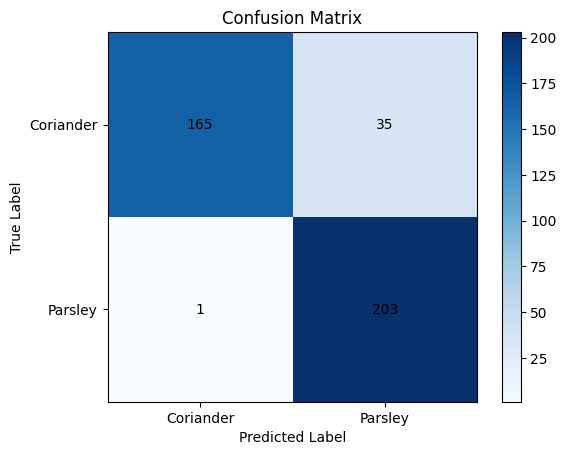

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt


# Define class labels
class_labels = ['Coriander', 'Parsley']

# Generate the plot
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

# Fill the plot with values
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
#best_model.predict(val_ds)

{'loss': [0.6211499571800232, 0.255165159702301, 0.15310536324977875, 0.05539000779390335, 0.058247752487659454, 0.07590518891811371, 0.06794055551290512, 0.11751222610473633, 0.10503070801496506, 0.022613203153014183, 0.07694292813539505, 0.045379843562841415, 0.02608729526400566, 0.03414583578705788, 0.011411123909056187, 0.017430126667022705, 0.02662852592766285, 0.01279362477362156, 0.0003412271908018738, 0.0001000292832031846, 7.402634219033644e-05, 5.582070298260078e-05, 4.159456875640899e-05, 3.825005842372775e-05, 3.25047476508189e-05, 2.7798629162134603e-05, 2.1134432245162316e-05, 1.9198987502022646e-05, 1.58901766553754e-05, 1.4495509276457597e-05, 1.3439035683404654e-05, 1.1474787243059836e-05, 1.2392937605909538e-05, 1.0659089639375452e-05, 9.331273759016767e-06, 8.282122507807799e-06, 1.0057859981316142e-05, 8.492007509630639e-06, 6.542931714648148e-06, 6.203549219208071e-06, 5.3053263400215656e-06, 5.1044598876615055e-06, 4.449739662959473e-06, 4.58819386039977e-06, 4.51

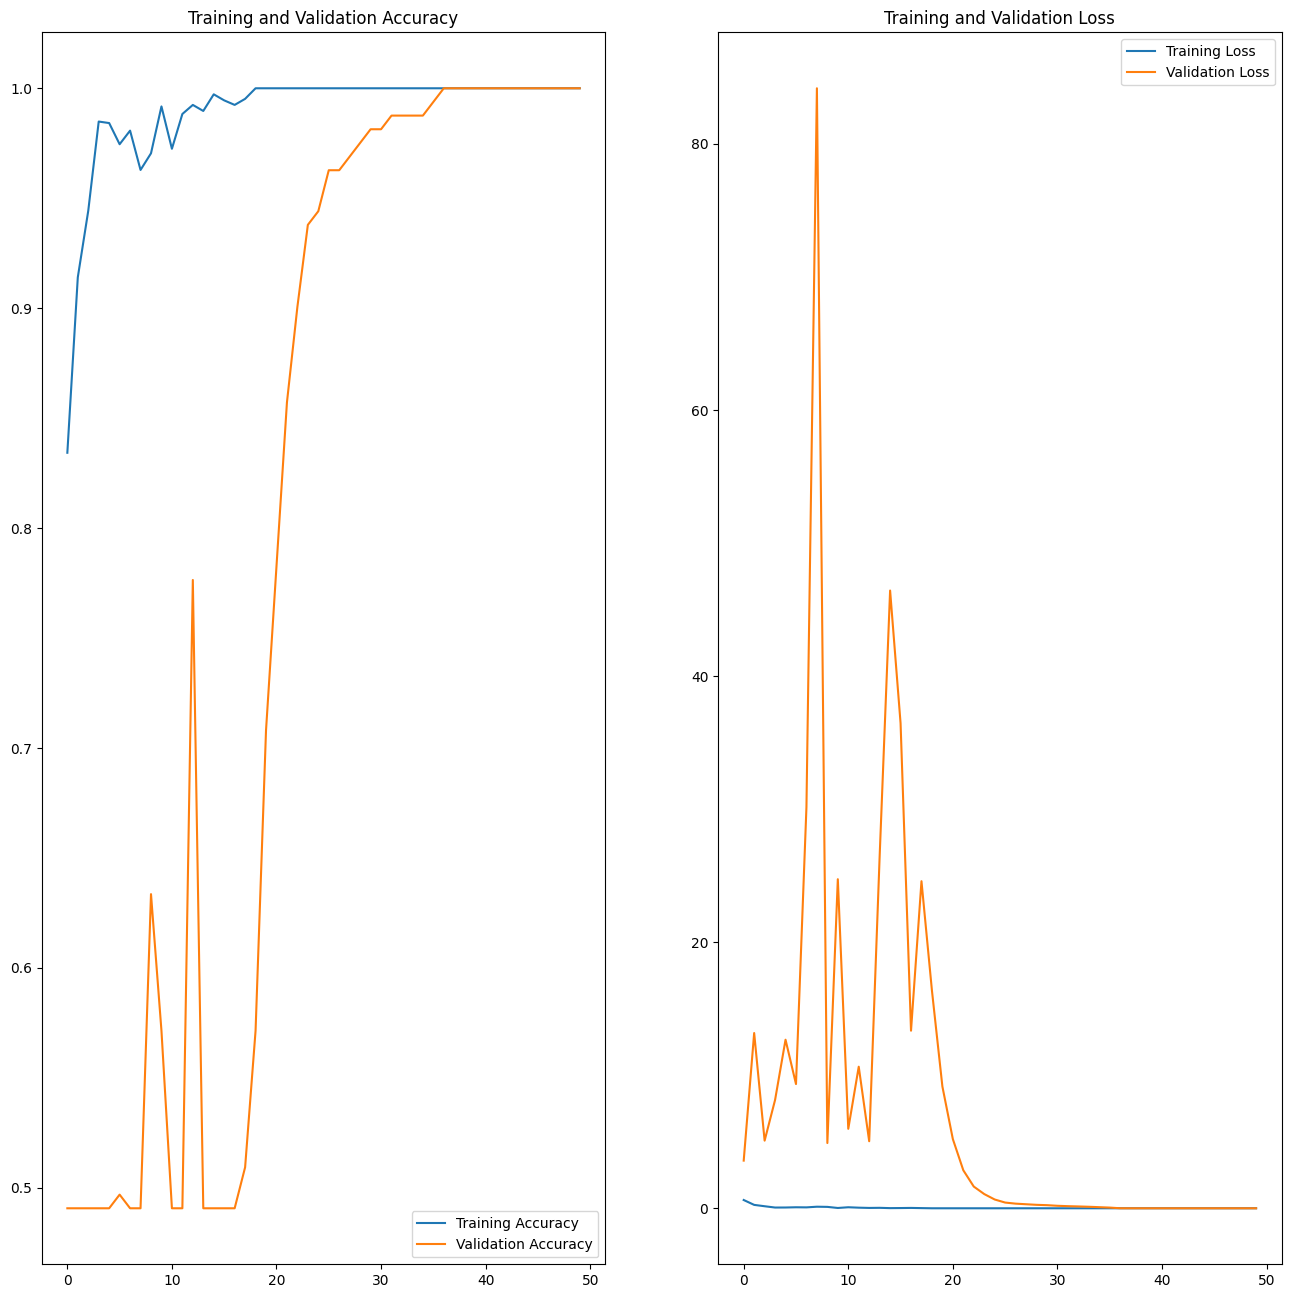

In [ ]:
history = results.history
print(history)

epochs = EPOCHS
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

fig = plt.figure(figsize=(16, 16))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
fig.savefig(MODEL_PATH_ROOT+'1.training fig.png', dpi=400)
plt.show()

In [ ]:
import pandas as pd
model_report = classification_report(labelsTrue, pred_digits, target_names=activity_labels,output_dict=True)
df = pd.DataFrame(model_report).transpose()

df

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
#predicting the data
y_pred_cnb = best_model.predict(val_ds)
#y_prob_pred_cnb = model.predict_proba(val_ds)

#roc auc score
roc_auc_score(labelsTrue, y_pred_cnb, multi_class='ovo', average='weighted')

In [ ]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(1):
    fpr[i], tpr[i], thresh[i] = roc_curve(labelsTrue, pred)

# plotting
plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Target vs No-Target')
plt.title('Binary classification ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

In [ ]:
json_config = best_model.to_json()
print(json_config)
with open(MODEL_PATH_ROOT+"/model_classification.json", "w") as json_file:
    json_file.write(json_config)